In [1]:
"""libraries"""
from dataclasses import dataclass
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde
import seaborn as sns

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
"""pickle handling functions"""
def load_object(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


def save_object(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [3]:
"""collection of useful analytic functions under Black-Scholes framework"""
def call_price(S, T, K, sigma, r):
    dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
    dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
    return S*norm.cdf(dp) - K*np.exp(-r*T)*norm.cdf(dm)

def put_price(S, T, K, sigma, r):
    dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
    dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
    return K*np.exp(-r*T)*norm.cdf(-dm) - S*norm.cdf(-dp)

def call_Delta(S, T, K, sigma, r):
    dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
    return norm.cdf(dp)

def put_Delta(S, T, K, sigma, r):
    return call_Delta(S, T, K, sigma, r) - 1

def call_Gamma(S, T, K, sigma, r):
    dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
    return norm.pdf(dp)/(S*sigma*np.sqrt(T))

def put_Gamma(S, T, K, sigma, r):
    return call_Gamma(S, T, K, sigma, r)
    
    
def sim(S_0, mu, sigma, N, T, N_paths):
    """generate simulated paths assuming geometric Brownian motion"""
    delta_t = T / N
    paths = np.full((N_paths, N+1), np.nan)
    paths[:, 0] = S_0
    for i in range(N):
        W = np.random.normal(0, np.sqrt(delta_t), N_paths)  # Wiener increments
        paths[:, i+1] = paths[:, i] * np.exp((mu - 0.5*sigma**2)*delta_t + sigma*W)
    return paths


def VaR(lst, q):
    return np.percentile(lst, 100*(1-q))


def CVaR(lst, q):
    var = VaR(lst, q)
    return np.mean(lst[lst<=var])

In [64]:
"""hedger class"""
"""this assumes we are hedging 1 unit of put option in short position using bank account, underlying equity, and call option"""
@dataclass
class HedgeResult:
    alpha: np.array = None
    beta: np.array = None
    eta: np.array = None
    band_center: np.array = None


class Hedger:
    def __init__(self, S, N, T_call, T_put, r, sigma, K_call, K_put, cost_equity, cost_option, band_size, edge_bands):
        # simulation
        self.S = S
        
        # parameters
        self.N = N
        self.T_call = T_call
        self.T_put = T_put
        self.r = r
        self.sigma = sigma
        self.K_call = K_call
        self.K_put = K_put
        self.cost_equity = cost_equity
        self.cost_option = cost_option
        self.band_size = band_size
        self.lower_edge, self.upper_edge = edge_bands
        
        # variables
        self.td_result = HedgeResult()
        self.tdg_result = HedgeResult()
        self.md_result = HedgeResult()
        self.mdg_result = HedgeResult()
    
    def hedge(self, hedge_type, convexity):
        if hedge_type not in ('time', 'move'):
            raise ValueError("the argument 'hedge_type' must be either 'time' or 'move'")
        if convexity not in ('delta', 'delta-gamma'):
            raise ValueError("the argument 'convexity' must be either 'delta' or 'delta-gamma'")
        if hedge_type == 'time':
            self._time_based_hedge(convexity)
        else:
            self._move_based_hedge(convexity)
            
    def hedge_all(self):
        for convexity in ('delta', 'delta-gamma'):
            self._time_based_hedge(convexity)
            self._move_based_hedge(convexity)
    
    def _time_based_hedge(self, convexity):
        delta_t = self.T_put / self.N
        alpha = np.full((self.S.shape[0], self.S.shape[1]-1), np.nan)  # number of equity shares
        beta = np.full((self.S.shape[0], self.S.shape[1]), np.nan)  # amount in bank account
        eta = np.full((self.S.shape[0], self.S.shape[1]-1), 0.0)  # number of option shares
        
        # t = 0
        if convexity == 'delta-gamma':
            eta[:, 0] = put_Gamma(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r) / call_Gamma(self.S[:, 0], self.T_call, self.K_call, self.sigma, self.r)
        alpha[:, 0] = put_Delta(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r) - eta[:, 0]*call_Delta(self.S[:, 0], self.T_call, self.K_call, self.sigma, self.r)
        transaction_cost = self.cost_equity * np.abs(alpha[:, 0]) + self.cost_option * np.abs(eta[:, 0])
        beta[:, 0] = put_price(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r) - alpha[:, 0]*self.S[:, 0] - eta[:, 0]*call_price(self.S[:, 0], self.T_call, self.K_call, self.sigma, self.r) - transaction_cost
        
        for n in range(1, self.N):
            t = n * delta_t
            if convexity == 'delta-gamma':
                eta[:, n] = put_Gamma(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r) / call_Gamma(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r)
            alpha[:, n] = put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r) - eta[:, n]*call_Delta(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r)
            transaction_cost = self.cost_equity * np.abs(alpha[:, n] - alpha[:, n-1]) + self.cost_option * np.abs(eta[:, n] - eta[:, n-1])
            beta[:, n] = beta[:, n-1]*np.exp(self.r*delta_t) - (alpha[:, n] - alpha[:, n-1])*self.S[:, n] - (eta[:, n] - eta[:, n-1])*call_price(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r) - transaction_cost
        
        # t = T
        payoff = np.maximum(self.K_put - self.S[:, self.N], 0)
        transaction_cost = self.cost_equity * np.abs(alpha[:, self.N-1]) + self.cost_option * np.abs(eta[:, self.N-1])
        beta[:, self.N] = beta[:, self.N-1]*np.exp(self.r*delta_t) + alpha[:, self.N-1]*self.S[:, self.N] + eta[:, self.N-1]*call_price(self.S[:, self.N], self.T_call-self.T_put, self.K_call, self.sigma, self.r) - payoff - transaction_cost
        
        # store the results
        if convexity == 'delta-gamma':
            self.tdg_result = HedgeResult(alpha, beta, eta, None)
        else:
            self.td_result = HedgeResult(alpha, beta, None, None)
    
    def _move_based_hedge(self, convexity):
        delta_t = self.T_put / self.N
        alpha = np.full((self.S.shape[0], self.S.shape[1]-1), np.nan)  # number of equity shares
        beta = np.full((self.S.shape[0], self.S.shape[1]), np.nan)  # amount in bank account
        eta = np.full((self.S.shape[0], self.S.shape[1]-1), 0.0)  # number of option shares
        band_center = np.full((self.S.shape[0], self.S.shape[1]-1), np.nan)
        
        # t = 0
        if convexity == 'delta-gamma':
            eta[:, 0] = put_Gamma(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r) / call_Gamma(self.S[:, 0], self.T_call, self.K_call, self.sigma, self.r)
        alpha[:, 0] = put_Delta(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r) - eta[:, 0]*call_Delta(self.S[:, 0], self.T_call, self.K_call, self.sigma, self.r)
        # band_center[:, 0] = put_Delta(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r)
        ## band_center[:, 0] = alpha[:, 0] + eta[:, 0]*call_Delta(self.S[:, 0], self.T_call, self.K_call, self.sigma, self.r) if convexity == 'delta-gamma' else put_Delta(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r)
        band_center[:, 0] = 0.0 if convexity == 'delta-gamma' else put_Delta(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r)
        transaction_cost = self.cost_equity * np.abs(alpha[:, 0]) + self.cost_option * np.abs(eta[:, 0])
        beta[:, 0] = put_price(self.S[:, 0], self.T_put, self.K_put, self.sigma, self.r) - alpha[:, 0]*self.S[:, 0] - eta[:, 0]*call_price(self.S[:, 0], self.T_call, self.K_call, self.sigma, self.r) - transaction_cost
        
        last_update = np.zeros(shape=(self.S.shape[0],))
        for n in range(1, self.N):
            t = n * delta_t
            # change the band calculations depending on how Delta bands are determined
            # lower_band = np.where(band_center[:, n-1] >= self.lower_edge, np.maximum(band_center[:, n-1] - self.band_size/2, self.lower_edge), -1)
            # upper_band = np.where(band_center[:, n-1] <= self.upper_edge, np.minimum(band_center[:, n-1] + self.band_size/2, self.upper_edge), 0)
            lower_band = np.where(band_center[:, n-1] >= (-np.inf if convexity == 'delta-gamma' else self.lower_edge), np.maximum(band_center[:, n-1] - self.band_size/2, (-np.inf if convexity == 'delta-gamma' else self.lower_edge)), -np.inf)  # -1
            upper_band = np.where(band_center[:, n-1] <= (np.inf if convexity == 'delta-gamma' else self.upper_edge), np.minimum(band_center[:, n-1] + self.band_size/2, (np.inf if convexity == 'delta-gamma' else self.upper_edge)), np.inf)  # 0
            # current_Delta = put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r)
            ## current_Delta = alpha[:, n-1] + eta[:, n-1]*call_Delta(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r) if convexity == 'delta-gamma' else put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r)
            current_Delta = put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r) - (alpha[:, n-1] + eta[:, n-1]*call_Delta(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r) if convexity == 'delta-gamma' else 0.0)
            last_update[(current_Delta < lower_band) | (current_Delta > upper_band)] = n
            if convexity == 'delta-gamma':
                eta[:, n] = eta[:, n-1]
                eta[last_update == n, n] = (put_Gamma(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r) / call_Gamma(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r))[last_update == n]
            alpha[:, n] = alpha[:, n-1]
            alpha[last_update == n, n] = (put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r) - eta[:, n]*call_Delta(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r))[last_update == n]
            band_center[:, n] = band_center[:, n-1]
            # band_center[last_update == n, n] = put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r)[last_update == n]
            ## band_center[last_update == n, n] = (alpha[:, n] + eta[:, n]*call_Delta(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r) if convexity == 'delta-gamma' else put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r))[last_update == n]
            band_center[last_update == n, n] = 0.0 if convexity == 'delta-gamma' else put_Delta(self.S[:, n], self.T_put-t, self.K_put, self.sigma, self.r)[last_update == n]
            transaction_cost = self.cost_equity * np.abs(alpha[:, n] - alpha[:, n-1]) + self.cost_option * np.abs(eta[:, n] - eta[:, n-1])
            beta[:, n] = beta[:, n-1]*np.exp(self.r*delta_t) - (alpha[:, n] - alpha[:, n-1])*self.S[:, n] - (eta[:, n] - eta[:, n-1])*call_price(self.S[:, n], self.T_call-t, self.K_call, self.sigma, self.r) - transaction_cost
        
        # t = T
        payoff = np.maximum(self.K_put - self.S[:, self.N], 0)
        transaction_cost = self.cost_equity * np.abs(alpha[:, self.N-1]) + self.cost_option * np.abs(eta[:, self.N-1])
        beta[:, self.N] = beta[:, self.N-1]*np.exp(self.r*delta_t) + alpha[:, self.N-1]*self.S[:, self.N] + eta[:, self.N-1]*call_price(self.S[:, self.N], self.T_call-self.T_put, self.K_call, self.sigma, self.r) - payoff - transaction_cost
        
        # store the results
        if convexity == 'delta-gamma':
            self.mdg_result = HedgeResult(alpha, beta, eta, band_center)
        else:
            self.md_result = HedgeResult(alpha, beta, None, band_center)

In [100]:
"""main run"""
np.random.seed(1928)

S_0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
T_call = 0.5
T_put = 0.25
K_call = 100
K_put = 100
cost_equity = 0.005
cost_option = 0.01
# cost_equity = 0.0
# cost_option = 0.0
band_size = 0.1
edge_bands = (-0.99, -0.01)
# edge_bands = (-np.inf, np.inf)
N_paths = 5000
N = 90
desired_CVaR = -0.02
discount_factor = 1.0  # np.exp(-r*T_put)
discount_factor_charge = np.exp(-r*T_put)

S = sim(S_0, mu, sigma, N, T_put, N_paths)
# save_object(S, "sim_object.pickle")
S = load_object('sim_object.pickle')
hedger = Hedger(S, N, T_call, T_put, r, sigma, K_call, K_put, cost_equity, cost_option, band_size, edge_bands)
hedger.hedge_all()

discounted VaR for time-based Delta hedging: -0.4353441808861109
discounted CVaR for time-based Delta hedging: -0.6847802172845858
discounted charge for time-based Delta hedging: 4.394772549039461


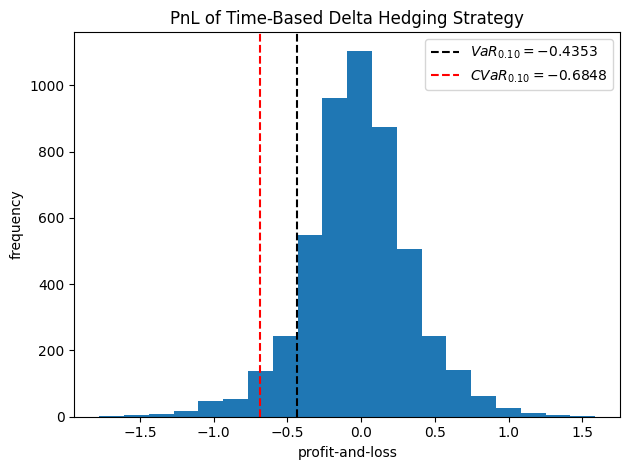

In [101]:
"""time-based Delta hedging"""
raw_VaR = VaR(hedger.td_result.beta[:, -1]*discount_factor, 0.90)
raw_CVaR = CVaR(hedger.td_result.beta[:, -1]*discount_factor, 0.90)
charge = put_price(S_0, T_put, K_put, sigma, r) + desired_CVaR - raw_CVaR*discount_factor_charge
print(f"discounted VaR for time-based Delta hedging: {raw_VaR}")
print(f"discounted CVaR for time-based Delta hedging: {raw_CVaR}")
print(f"discounted charge for time-based Delta hedging: {charge}")
fig, ax = plt.subplots()
ax.hist(hedger.td_result.beta[:, -1]*discount_factor, bins=20)
ax.axvline(x=raw_VaR, color='k', label=f"$VaR_{{0.10}} = {{{raw_VaR:.4f}}}$", linestyle="dashed")
ax.axvline(x=raw_CVaR, color='r', label=f"$CVaR_{{0.10}} = {{{raw_CVaR:.4f}}}$", linestyle="dashed")
ax.set(xlabel='profit-and-loss', ylabel='frequency')
ax.set_title("PnL of Time-Based Delta Hedging Strategy")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("td.png")

discounted VaR for time-based Delta-Gamma hedging: -0.25606133203776377
discounted CVaR for time-based Delta-Gamma hedging: -0.34464775512147605
discounted charge for time-based Delta-Gamma hedging: 4.056336504608633


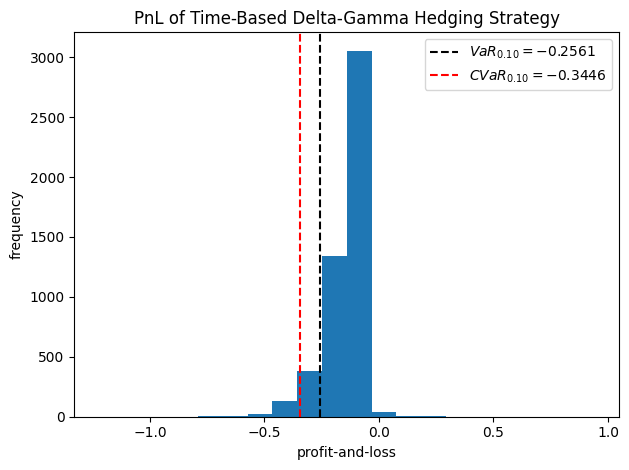

In [102]:
"""time-based Delta-Gamma hedging"""
raw_VaR = VaR(hedger.tdg_result.beta[:, -1]*discount_factor, 0.90)
raw_CVaR = CVaR(hedger.tdg_result.beta[:, -1]*discount_factor, 0.90)
charge = put_price(S_0, T_put, K_put, sigma, r) + desired_CVaR - raw_CVaR*discount_factor_charge
print(f"discounted VaR for time-based Delta-Gamma hedging: {raw_VaR}")
print(f"discounted CVaR for time-based Delta-Gamma hedging: {raw_CVaR}")
print(f"discounted charge for time-based Delta-Gamma hedging: {charge}")
fig, ax = plt.subplots()
ax.hist(hedger.tdg_result.beta[:, -1]*discount_factor, bins=20)
ax.axvline(x=raw_VaR, color='k', label=f"$VaR_{{0.10}} = {{{raw_VaR:.4f}}}$", linestyle="dashed")
ax.axvline(x=raw_CVaR, color='r', label=f"$CVaR_{{0.10}} = {{{raw_CVaR:.4f}}}$", linestyle="dashed")
ax.set(xlabel='profit-and-loss', ylabel='frequency')
ax.set_title("PnL of Time-Based Delta-Gamma Hedging Strategy")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("tdg.png")

discounted VaR for move-based Delta hedging: -0.5334021385114012
discounted CVaR for move-based Delta hedging: -0.77141762283088
discounted charge for move-based Delta hedging: 4.4809778487229


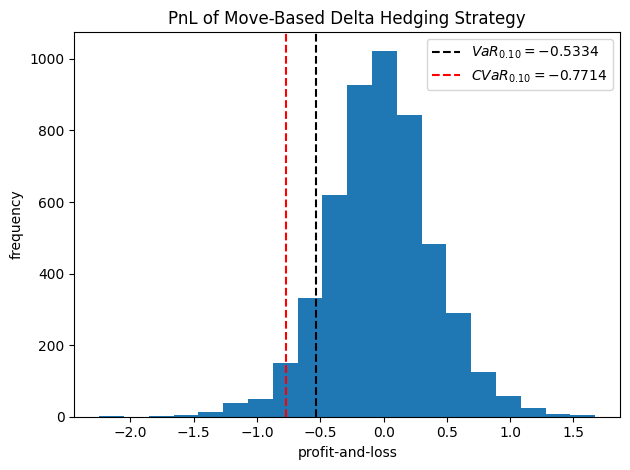

In [103]:
"""move-based Delta hedging"""
raw_VaR = VaR(hedger.md_result.beta[:, -1]*discount_factor, 0.90)
raw_CVaR = CVaR(hedger.md_result.beta[:, -1]*discount_factor, 0.90)
charge = put_price(S_0, T_put, K_put, sigma, r) + desired_CVaR - raw_CVaR*discount_factor_charge
print(f"discounted VaR for move-based Delta hedging: {raw_VaR}")
print(f"discounted CVaR for move-based Delta hedging: {raw_CVaR}")
print(f"discounted charge for move-based Delta hedging: {charge}")
fig, ax = plt.subplots()
ax.hist(hedger.md_result.beta[:, -1]*discount_factor, bins=20)
ax.axvline(x=raw_VaR, color='k', label=f"$VaR_{{0.10}} = {{{raw_VaR:.4f}}}$", linestyle="dashed")
ax.axvline(x=raw_CVaR, color='r', label=f"$CVaR_{{0.10}} = {{{raw_CVaR:.4f}}}$", linestyle="dashed")
ax.set(xlabel='profit-and-loss', ylabel='frequency')
ax.set_title("PnL of Move-Based Delta Hedging Strategy")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("md.png")

discounted VaR for move-based Delta-Gamma hedging: -0.30659417325239735
discounted CVaR for move-based Delta-Gamma hedging: -0.40038682020437566
discounted charge for move-based Delta-Gamma hedging: 4.111797569944652


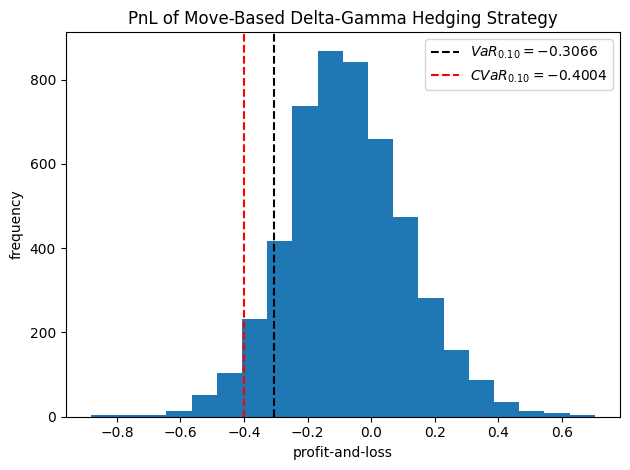

In [104]:
"""move-based Delta-Gamma hedging"""
raw_VaR = VaR(hedger.mdg_result.beta[:, -1]*discount_factor, 0.90)
raw_CVaR = CVaR(hedger.mdg_result.beta[:, -1]*discount_factor, 0.90)
charge = put_price(S_0, T_put, K_put, sigma, r) + desired_CVaR - raw_CVaR*discount_factor_charge
print(f"discounted VaR for move-based Delta-Gamma hedging: {raw_VaR}")
print(f"discounted CVaR for move-based Delta-Gamma hedging: {raw_CVaR}")
print(f"discounted charge for move-based Delta-Gamma hedging: {charge}")
fig, ax = plt.subplots()
ax.hist(hedger.mdg_result.beta[:, -1]*discount_factor, bins=20)
ax.axvline(x=raw_VaR, color='k', label=f"$VaR_{{0.10}} = {{{raw_VaR:.4f}}}$", linestyle="dashed")
ax.axvline(x=raw_CVaR, color='r', label=f"$CVaR_{{0.10}} = {{{raw_CVaR:.4f}}}$", linestyle="dashed")
ax.set(xlabel='profit-and-loss', ylabel='frequency')
ax.set_title("PnL of Move-Based Delta-Gamma Hedging Strategy")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("mdg.png")

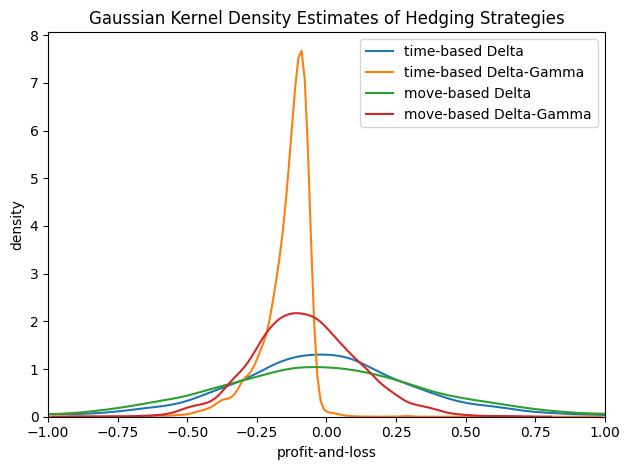

In [105]:
"""Gaussian kernel density estimates"""
fig, ax = plt.subplots()
sns.kdeplot(hedger.td_result.beta[:, -1]*discount_factor, label="time-based Delta")
sns.kdeplot(hedger.tdg_result.beta[:, -1]*discount_factor, label="time-based Delta-Gamma")
sns.kdeplot(hedger.md_result.beta[:, -1]*discount_factor, label="move-based Delta")
sns.kdeplot(hedger.mdg_result.beta[:, -1]*discount_factor, label="move-based Delta-Gamma")
ax.set(xlabel='profit-and-loss', ylabel='density')
ax.set_title("Gaussian Kernel Density Estimates of Hedging Strategies")
ax.legend()
plt.xlim((-1, 1))
plt.tight_layout()
plt.show()
fig.savefig("kde.png")

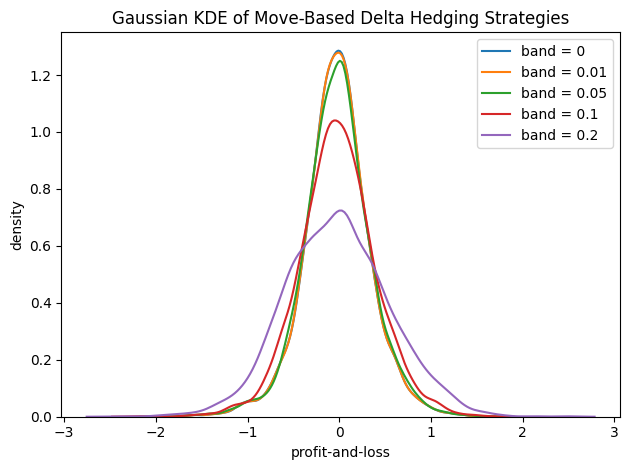

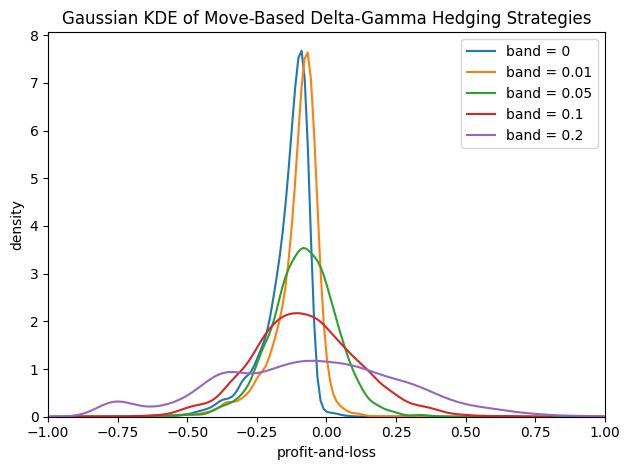

In [106]:
hedgers = [Hedger(S, N, T_call, T_put, r, sigma, K_call, K_put, cost_equity, cost_option, band_size, edge_bands) for band_size in (0, 0.01, 0.05, 0.1, 0.2)]
for hedger in hedgers:
    hedger.hedge_all()

fig, ax = plt.subplots()
for hedger in hedgers:
    sns.kdeplot(hedger.md_result.beta[:, -1]*discount_factor, label=f"band = {hedger.band_size}")
ax.set(xlabel='profit-and-loss', ylabel='density')
ax.set_title("Gaussian KDE of Move-Based Delta Hedging Strategies")
ax.legend()
# plt.xlim((-0.75, 0.75))
plt.tight_layout()
plt.show()
fig.savefig("kde_md.png")

fig, ax = plt.subplots()
for hedger in hedgers:
    sns.kdeplot(hedger.mdg_result.beta[:, -1]*discount_factor, label=f"band = {hedger.band_size}")
ax.set(xlabel='profit-and-loss', ylabel='density')
ax.set_title("Gaussian KDE of Move-Based Delta-Gamma Hedging Strategies")
ax.legend()
plt.xlim((-1, 1))
plt.tight_layout()
plt.show()
fig.savefig("kde_mdg.png")